通过“隐马尔科夫”模型进行预测，通过两个函数实现：
1. GHMM_Generate(Sec)：通过历史状态，生成相应的状态
2. single_state_estimation(Sec,model_read,enddate = "2018-12-20")：通过获取参数，通过已经存储的状态预测未来的状态


HMM常用的三种模型 
1. GaussianHMM 观测状态连续型且符合高斯分布 
2. GMMHMM 观测状态连续型且符合混合高斯分布 
3. MultinomialHMM 观测状态离散型



In [1]:
# from hmmlearn.hmm import GaussianHMM
from hmmlearn import hmm
import numpy as np
from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates
import pandas as pd
from datetime import timedelta,date

import warnings
warnings.filterwarnings("ignore")

def GHMM_Generate(Sec):
    
    beginDate = '2006-1-1'
    endDate = '2014-12-30'
    n_state = 4

    data_raw = get_price(Sec, start_date = beginDate, end_date=endDate, frequency='daily', fields=['close','volume','money'],fq = "pre")
    
    
    logRet_5 = np.log(np.array(data_raw['close'][5:])) - np.log(np.array(data_raw['close'][:-5]))

    logRet_20 = np.log(np.array(data_raw['close'][20:])) - np.log(np.array(data_raw['close'][:-20]))

    logVol_5 = np.log(np.array(data_raw['volume'][5:])) - np.log(np.array(data_raw['volume'][:-5]))

    logVol_20 = np.log(np.array(data_raw['volume'][20:])) - np.log(np.array(data_raw['volume'][:-20]))

    logMoney_5 = np.log(np.array(data_raw['money'][5:])) - np.log(np.array(data_raw['money'][:-5]))

    logMoney_20 = np.log(np.array(data_raw['money'][20:])) - np.log(np.array(data_raw['money'][:-20]))

    std = pd.rolling_std(data_raw['close'].pct_change(),20)

    data_len = len(data_raw['close']) - 50

    Train_Data = np.column_stack([logRet_5[-data_len:], \
                              logRet_20[-data_len:], \
                              logVol_5[-data_len:], \
                              logVol_20[-data_len:], \
                              logMoney_5[-data_len:], \
                              logMoney_20[-data_len:], \
                              std[-data_len:]])
    
    
    Date = pd.to_datetime(data_raw.index[-data_len:])
    
    model = hmm.GaussianHMM(n_components= n_state, covariance_type="full", n_iter=2000).fit(Train_Data)

    hidden_states = model.predict(Train_Data)
    
    state_pd = pd.concat([pd.DataFrame(Date[-data_len:]),pd.DataFrame(list(hidden_states[-data_len:]))],axis = 1,names = ['date','state'])
    state_pd.columns = ['date','state']

    state_choose = state_pd[(state_pd['date'] > datetime.datetime.strptime("2008-1-1", "%Y-%m-%d"))&(state_pd['date'] < datetime.datetime.strptime("2008-10-31", "%Y-%m-%d"))]['state'].value_counts()
    state_BigLoss = state_choose[state_choose == state_choose.max()].index[0]

    state_choose = state_pd[(state_pd['date'] > datetime.datetime.strptime("2007-1-1", "%Y-%m-%d"))&(state_pd['date'] < datetime.datetime.strptime("2007-10-1", "%Y-%m-%d"))]['state'].value_counts()
    state_BigBonus = state_choose[state_choose == state_choose.max()].index[0]

    state_choose = state_pd[(state_pd['date'] > datetime.datetime.strptime("2011-1-1", "%Y-%m-%d"))&(state_pd['date'] < datetime.datetime.strptime("2013-1-1", "%Y-%m-%d"))]['state'].value_counts()
    state_MinorLoss = state_choose[state_choose == state_choose.max()].index[0]

    state_choose = state_pd[(state_pd['date'] > datetime.datetime.strptime("2014-6-1", "%Y-%m-%d"))&(state_pd['date'] < datetime.datetime.strptime("2014-12-31", "%Y-%m-%d"))]['state'].value_counts()
    state_MinorBonus = state_choose[state_choose == state_choose.max()].index[0]

    return model,state_BigLoss,state_BigBonus,state_MinorLoss,state_MinorBonus



def single_state_estimation(Sec,model_read,enddate = "2018-12-20"):
    HMM_model = model_read[0]
    state_BigLoss = model_read[1]
    state_BigBonus = model_read[2]
    state_MinorLoss = model_read[3]
    state_MinorBonus =  model_read[4]

    # 生成模型对应的参数
    data_raw = get_price(Sec, count = 100, end_date=enddate, frequency='daily', fields=['close','volume','money'],fq = "pre")

    logRet_5 = np.log(np.array(data_raw['close'][5:])) - np.log(np.array(data_raw['close'][:-5]))

    logRet_20 = np.log(np.array(data_raw['close'][20:])) - np.log(np.array(data_raw['close'][:-20]))

    logVol_5 = np.log(np.array(data_raw['volume'][5:])) - np.log(np.array(data_raw['volume'][:-5]))

    logVol_20 = np.log(np.array(data_raw['volume'][20:])) - np.log(np.array(data_raw['volume'][:-20]))

    logMoney_5 = np.log(np.array(data_raw['money'][5:])) - np.log(np.array(data_raw['money'][:-5]))

    logMoney_20 = np.log(np.array(data_raw['money'][20:])) - np.log(np.array(data_raw['money'][:-20]))

    std = pd.rolling_std(data_raw['close'].pct_change(),20)

    data_len = len(data_raw['close']) - 50


    Train_Data = np.column_stack([logRet_5[-data_len:], \
                                  logRet_20[-data_len:], \
                                  logVol_5[-data_len:], \
                                  logVol_20[-data_len:], \
                                  logMoney_5[-data_len:], \
                                  logMoney_20[-data_len:], \
                                  std[-data_len:]])
    
    

    hidden_states = HMM_model.predict(Train_Data)
    current_states = hidden_states[-1]
    
    if current_states == state_BigLoss:
        return 'bl'
    elif current_states == state_BigBonus:
        return 'bb'
    elif current_states == state_MinorLoss:
        return 'ml'
    elif current_states == state_MinorBonus:
        return 'mb'
    else:
        return 0
    


生成全量的价格信息表，步骤如下：
1. 生成预测模型
2. 生成日期、状态的序列
3. 生成价格序列




算法模型重点，其中需要调整：

1. 操作时间实际是在T时刻
2. 判断的依据是T时刻往前追溯的状态
3. 市场收益率应该是T时刻往后5天的收益率
4. 调整后的策略收益率应该是往后5天的收益率乘以仓位系数

In [2]:
# 生成模型
model_HMM = GHMM_Generate('000300.XSHG')

state_BigLoss = model_HMM[1]
state_BigBonus = model_HMM[2]
state_MinorLoss = model_HMM[3]
state_MinorBonus = model_HMM[4]

operate_date_list = get_price('000300.XSHG', start_date = '2015-1-1', end_date= '2018-8-31', frequency='daily', \
                        fields=['close','volume','money'],fq = "pre")['close'].index


# 生成状态序列
State_List = []
for date_i in list(operate_date_list):
    operate_date = date_i
    current_state = single_state_estimation('000300.XSHG',model_HMM,enddate = operate_date)
    State_List.append([operate_date,current_state])

# 转化为pandas数组
State_pd = pd.DataFrame(State_List)
State_pd.columns = ['date','state']
State_pd = State_pd.set_index("date")
 
    
# 生成价格序列
Date = State_pd.index

s_date = Date[0]
e_date = Date[-1]
market_close = get_price('000300.XSHG', start_date = s_date, end_date=e_date, frequency='daily', fields=['close'],fq = "pre")['close']

# 关键参数，看最终往后延续多少天
market_close_next = market_close.shift(-1)
market_close_diff = market_close_next - market_close

data_total_pd = pd.concat([market_close,market_close_next,market_close_diff],axis =1)

data_total_pd.columns = ['price_raw','price_next','price_diff']

# 相应的状态取自markov预测的状态
data_total_pd['state'] = State_pd

# 仓位的关键参数，初始值默认为1，每次循环要重新赋值
alpha = np.ones(len(market_close_diff))
data_total_pd['alpha'] = alpha

# 评分，评分初始值默认为0，每次循环要重新赋值
score = np.zeros(len(market_close_diff))
data_total_pd['score'] = score

# 评分，评分初始值默认为0，每次循环要重新赋值
score = np.zeros(len(market_close_diff))
data_total_pd['market_yield'] = np.log(data_total_pd['price_next']/data_total_pd['price_raw'])

# 通过仓位调整后的收益率
data_total_pd['adjust_yield'] = np.zeros(len(market_close_diff))

In [3]:
data_total_pd.fillna(0,inplace =True)
# 写入生成文件，最终文件格式如下
# write_file('data_total.csv', data_total_pd.to_csv(), append=False)


data_total_pd


,price_raw,price_next,price_diff,state,alpha,score,market_yield,adjust_yield
2015-01-05,3641.54,3641.06,-0.48,bb,1,0,-0.000132,0
2015-01-06,3641.06,3643.79,2.73,bb,1,0,0.000750,0
2015-01-07,3643.79,3559.26,-84.53,bb,1,0,-0.023472,0
2015-01-08,3559.26,3546.72,-12.54,bb,1,0,-0.003529,0
2015-01-09,3546.72,3513.58,-33.14,bb,1,0,-0.009388,0
2015-01-12,3513.58,3514.04,0.46,bb,1,0,0.000131,0
2015-01-13,3514.04,3502.42,-11.62,bb,1,0,-0.003312,0
2015-01-14,3502.42,3604.12,101.70,bb,1,0,0.028623,0
2015-01-15,3604.12,3635.15,31.03,bb,1,0,0.008573,0
2015-01-16,3635.15,3355.16,-279.99,bb,1,0,-0.080151,0


打分函数cal_score(data_total_pd,n,score_BigBonus,score_BigLoss,score_MinorBonus,score_MinorLoss)，参数说明：
1. data_total_pd：格式参照以上的文件
2. n:往前追溯的日期数
3. 几个状态打分的分值

In [5]:
def cal_score(data_total_pd,n,score_BigBonus,score_BigLoss,score_MinorBonus,score_MinorLoss):
    # 每个日期进行循环比对
    date_operate = data_total_pd.index
    
    score_list = []
    for date_i in date_operate[:]:

        # 状态的pandas数组
        States_pd_current = data_total_pd[(data_total_pd.index <= date_i)&(data_total_pd.index > (date_i - timedelta(days = n)))]

        score_current = 0
        for index, row in States_pd_current.iterrows():
            if row['state'] == "bb":
                score_current += score_BigBonus
            elif row['state'] == "bl":
                score_current += score_BigLoss
            elif row['state'] == "mb":
                score_current += score_MinorBonus
            elif row['state'] == "ml":
                score_current += score_MinorLoss
        score_list.append(score_current)

    data_total_pd['score'] = np.array(score_list)
    return data_total_pd


寻找最佳参数，步骤：
1. 通过设置总分数
2. 对每个分值进行循环，生成参数列表
3. 对参数列表进行分析、筛选


In [ ]:
# 上限总分值：10分
total_score = 10

# 开始循环，寻找合理参数
# 存储参数的数组
para_list = []
i = 0
for score_BigLoss in range(-10,3,3):
    for score_BigBonus in range(-3,10,3):
        for score_MinorLoss in range(-10,3,3):
            for score_MinorBonus in range(-3,10,3):
                for n_windows in range(0,10):

                    # 标识目前的进度                   
                    i += 1
                    print "%d、正在计算：n为%d,score_BigBonus为%d,score_BigLoss为%d,score_MinorBonus为%d,score_MinorLoss为%d" \
                         %(i,n_windows,score_BigBonus,score_BigLoss,score_MinorBonus,score_MinorLoss)
    
                    # 列表中几个参数需要赋初值

                    # 仓位的关键参数，初始值默认为1，每次循环要重新赋值
                    alpha = np.ones(len(market_close_diff))
                    data_total_pd['alpha'] = alpha

                    # 评分，评分初始值默认为0，每次循环要重新赋值
                    score = np.zeros(len(market_close_diff))
                    data_total_pd['score'] = score

                    # 通过仓位调整后的收益率，每次循环要重新赋值
                    data_total_pd['adjust_yield'] = np.zeros(len(market_close_diff))

                    data_total_pd = cal_score(data_total_pd,n_windows,score_BigBonus,score_BigLoss,score_MinorBonus,score_MinorLoss)

                    data_total_pd['alpha'] = np.where(data_total_pd['score'] > 0,data_total_pd['score']/total_score,0)

                    data_total_pd['adjust_yield'] =  \
                            np.log( 1 + data_total_pd['alpha'] * data_total_pd['price_diff'] / data_total_pd['price_raw'])

                    # 计算胜率
                    win_rate = \
                        float(sum(data_total_pd['adjust_yield'] > data_total_pd['market_yield'])) / float(len(data_total_pd['adjust_yield']))

                    if sum(data_total_pd['adjust_yield']) > sum(data_total_pd['market_yield']):
                        if win_rate > 0.5:
                            para_list.append([n_windows,score_BigBonus,score_BigLoss,score_MinorBonus,score_MinorLoss,win_rate,sum(data_total_pd['adjust_yield'])])
                            # 提示                   
                            print "找到参数组：n为%d,score_BigBonus为%d,score_BigLoss为%d,score_MinorBonus为%d,score_MinorLoss为%d，胜率为%f，收益率为%f" \
                                    %(n_windows,score_BigBonus,score_BigLoss,score_MinorBonus,score_MinorLoss,win_rate,sum(data_total_pd['adjust_yield']))



1、正在计算：n为0,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
2、正在计算：n为1,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
3、正在计算：n为2,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
4、正在计算：n为3,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
5、正在计算：n为4,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
6、正在计算：n为5,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
7、正在计算：n为6,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
8、正在计算：n为7,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
9、正在计算：n为8,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
10、正在计算：n为9,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
11、正在计算：n为0,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为-10
12、正在计算：n为1,score_BigBonus为-3,score_BigLos

73、正在计算：n为2,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
74、正在计算：n为3,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
75、正在计算：n为4,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
76、正在计算：n为5,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
77、正在计算：n为6,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
找到参数组：n为6,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7，胜率为0.516741，收益率为0.439289
78、正在计算：n为7,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
找到参数组：n为7,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7，胜率为0.508929，收益率为0.406967
79、正在计算：n为8,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
找到参数组：n为8,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7，胜率为0.506696，收益率为0.439584
80、正在计算：n为9,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为3,scor

找到参数组：n为6,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-4，胜率为0.517857，收益率为0.696815
138、正在计算：n为7,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-4
找到参数组：n为7,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-4，胜率为0.506696，收益率为0.633678
139、正在计算：n为8,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-4
找到参数组：n为8,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-4，胜率为0.512277，收益率为0.619199
140、正在计算：n为9,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-4
找到参数组：n为9,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-4，胜率为0.514509，收益率为0.461789
141、正在计算：n为0,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-4
142、正在计算：n为1,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-4
143、正在计算：n为2,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-4
找到参数组：n为2,score_BigBonus为-3,score_BigLoss为

找到参数组：n为9,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-1，胜率为0.523438，收益率为0.229595
201、正在计算：n为0,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为2
202、正在计算：n为1,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为2
203、正在计算：n为2,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为2
204、正在计算：n为3,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为2
205、正在计算：n为4,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为2
206、正在计算：n为5,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为2
207、正在计算：n为6,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为2
208、正在计算：n为7,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为2
209、正在计算：n为8,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为2
210、正在计算：n为9,score_BigBonus为-3,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为2
211、正在计算：n为0,score_Bi

找到参数组：n为7,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-10，胜率为0.510045，收益率为0.360723
279、正在计算：n为8,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-10
找到参数组：n为8,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-10，胜率为0.504464，收益率为0.408694
280、正在计算：n为9,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-10
找到参数组：n为9,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-10，胜率为0.502232，收益率为0.404382
281、正在计算：n为0,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-10
282、正在计算：n为1,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-10
283、正在计算：n为2,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-10
找到参数组：n为2,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-10，胜率为0.501116，收益率为0.261889
284、正在计算：n为3,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-10
285、正在计算：n为4,score_BigBonus为0,score_BigLos

找到参数组：n为9,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-7，胜率为0.506696，收益率为0.532059
341、正在计算：n为0,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-7
342、正在计算：n为1,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-7
343、正在计算：n为2,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-7
找到参数组：n为2,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-7，胜率为0.501116，收益率为0.360308
344、正在计算：n为3,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-7
345、正在计算：n为4,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-7
找到参数组：n为4,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-7，胜率为0.513393，收益率为0.457451
346、正在计算：n为5,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-7
找到参数组：n为5,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-7，胜率为0.512277，收益率为0.757734
347、正在计算：n为6,score_BigBonus为0,score_BigLoss为-10,scor

404、正在计算：n为3,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-1
405、正在计算：n为4,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-1
406、正在计算：n为5,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-1
407、正在计算：n为6,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-1
408、正在计算：n为7,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-1
409、正在计算：n为8,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-1
410、正在计算：n为9,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-1
411、正在计算：n为0,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为-1
412、正在计算：n为1,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为-1
413、正在计算：n为2,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为-1
414、正在计算：n为3,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为-1
415、正在计算：n为4,score_BigBonus为0,score_BigLoss为-10

479、正在计算：n为8,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为2
找到参数组：n为8,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为2，胜率为0.501116，收益率为0.373020
480、正在计算：n为9,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为2
找到参数组：n为9,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为2，胜率为0.502232，收益率为0.290253
481、正在计算：n为0,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为2
482、正在计算：n为1,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为2
483、正在计算：n为2,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为2
找到参数组：n为2,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为2，胜率为0.501116，收益率为0.209987
484、正在计算：n为3,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为2
485、正在计算：n为4,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为2
找到参数组：n为4,score_BigBonus为0,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为2，胜率

找到参数组：n为4,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-10，胜率为0.522321，收益率为0.403132
546、正在计算：n为5,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-10
找到参数组：n为5,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-10，胜率为0.516741，收益率为0.675653
547、正在计算：n为6,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-10
找到参数组：n为6,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-10，胜率为0.521205，收益率为0.782259
548、正在计算：n为7,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-10
找到参数组：n为7,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-10，胜率为0.523438，收益率为0.610175
549、正在计算：n为8,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-10
找到参数组：n为8,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-10，胜率为0.516741，收益率为0.532649
550、正在计算：n为9,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-10
找到参数组：n为9,score_BigB

613、正在计算：n为2,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为-4
614、正在计算：n为3,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为-4
615、正在计算：n为4,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为-4
616、正在计算：n为5,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为-4
617、正在计算：n为6,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为-4
618、正在计算：n为7,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为-4
619、正在计算：n为8,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为-4
620、正在计算：n为9,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为-4
621、正在计算：n为0,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-4
622、正在计算：n为1,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-4
623、正在计算：n为2,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-4
624、正在计算：n为3,score_BigBonus为3,score_BigLoss为-10,score_

685、正在计算：n为4,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-1
找到参数组：n为4,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-1，胜率为0.508929，收益率为0.262642
686、正在计算：n为5,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-1
找到参数组：n为5,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-1，胜率为0.510045，收益率为0.446349
687、正在计算：n为6,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-1
找到参数组：n为6,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-1，胜率为0.512277，收益率为0.520464
688、正在计算：n为7,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-1
找到参数组：n为7,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-1，胜率为0.520089，收益率为0.424865
689、正在计算：n为8,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-1
找到参数组：n为8,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-1，胜率为0.522321，收益率为0.348948
690、正在计算：n为9,score_BigBonus为3,

找到参数组：n为9,score_BigBonus为3,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为2，胜率为0.515625，收益率为0.024052
751、正在计算：n为0,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
752、正在计算：n为1,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
753、正在计算：n为2,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
754、正在计算：n为3,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
755、正在计算：n为4,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
756、正在计算：n为5,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
757、正在计算：n为6,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
758、正在计算：n为7,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
759、正在计算：n为8,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
760、正在计算：n为9,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为-10
761、正在计算：n为0,

824、正在计算：n为3,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
825、正在计算：n为4,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
826、正在计算：n为5,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
827、正在计算：n为6,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
找到参数组：n为6,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7，胜率为0.516741，收益率为0.096473
828、正在计算：n为7,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
找到参数组：n为7,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7，胜率为0.508929，收益率为0.035750
829、正在计算：n为8,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
找到参数组：n为8,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7，胜率为0.507812，收益率为0.018175
830、正在计算：n为9,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为3,score_MinorLoss为-7
找到参数组：n为9,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为3,score_Mino

找到参数组：n为8,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-4，胜率为0.515625，收益率为0.199965
890、正在计算：n为9,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-4
找到参数组：n为9,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-4，胜率为0.515625，收益率为0.095755
891、正在计算：n为0,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-4
892、正在计算：n为1,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-4
893、正在计算：n为2,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-4
894、正在计算：n为3,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-4
895、正在计算：n为4,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-4
找到参数组：n为4,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-4，胜率为0.510045，收益率为0.228779
896、正在计算：n为5,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-4
找到参数组：n为5,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为9,score_Mino

959、正在计算：n为8,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为2
960、正在计算：n为9,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为-3,score_MinorLoss为2
961、正在计算：n为0,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为2
962、正在计算：n为1,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为2
963、正在计算：n为2,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为2
964、正在计算：n为3,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为2
965、正在计算：n为4,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为2
966、正在计算：n为5,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为2
967、正在计算：n为6,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为2
968、正在计算：n为7,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为2
969、正在计算：n为8,score_BigBonus为6,score_BigLoss为-10,score_MinorBonus为0,score_MinorLoss为2
970、正在计算：n为9,score_BigBonus为6,score_BigLoss为-10,score_MinorBonu

找到参数组：n为6,score_BigBonus为9,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-10，胜率为0.520089，收益率为0.177345
1038、正在计算：n为7,score_BigBonus为9,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-10
找到参数组：n为7,score_BigBonus为9,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-10，胜率为0.520089，收益率为0.090514
1039、正在计算：n为8,score_BigBonus为9,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-10
找到参数组：n为8,score_BigBonus为9,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-10，胜率为0.517857，收益率为0.019134
1040、正在计算：n为9,score_BigBonus为9,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-10
找到参数组：n为9,score_BigBonus为9,score_BigLoss为-10,score_MinorBonus为6,score_MinorLoss为-10，胜率为0.508929，收益率为-0.065301
1041、正在计算：n为0,score_BigBonus为9,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-10
1042、正在计算：n为1,score_BigBonus为9,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-10
1043、正在计算：n为2,score_BigBonus为9,score_BigLoss为-10,score_MinorBonus为9,score_MinorLoss为-10
1044、正在计算：n为3,score_BigBonus为9,scor

选取最佳参数，需要手工选取，生成最佳参数

In [ ]:

para_pd = pd.DataFrame(para_list)
para_pd.columns = ["n_windows",'score_BigBonus','score_BigLoss','score_MinorBonus','score_MinorLoss','胜率','收益率']

# write_file('best_para_HMM.csv', para_pd.to_csv(), append=False)
para_pd

通过最佳参数，生成完成的价格表：
1. 进行打分
2. 计算仓位

In [7]:
# 总分值
total_score = 10

# 仓位的关键参数，初始值默认为1，每次循环要重新赋值
alpha = np.ones(len(market_close_diff))
data_total_pd['alpha'] = alpha

# 评分，评分初始值默认为0，每次循环要重新赋值
score = np.zeros(len(market_close_diff))
data_total_pd['score'] = score

# 通过仓位调整后的收益率，每次循环要重新赋值
data_total_pd['adjust_yield'] = np.zeros(len(market_close_diff))

# 关键步骤：进行了参数设置，计算分值
data_total_pd = cal_score(data_total_pd,6,-3,-10,6,-7)

# 关键步骤：计算仓位
data_total_pd['alpha'] = np.where(data_total_pd['score'] > 0,data_total_pd['score']/total_score,0)

data_total_pd['adjust_yield'] =  \
        np.log( 1 + data_total_pd['alpha'] * data_total_pd['price_diff'] / data_total_pd['price_raw'])


In [8]:
data_total_pd

,price_raw,price_next,price_diff,state,alpha,score,market_yield,adjust_yield
2015-01-05,3641.54,3641.06,-0.48,bb,0.0,-3,-0.000132,0.000000
2015-01-06,3641.06,3643.79,2.73,bb,0.0,-6,0.000750,0.000000
2015-01-07,3643.79,3559.26,-84.53,bb,0.0,-9,-0.023472,0.000000
2015-01-08,3559.26,3546.72,-12.54,bb,0.0,-12,-0.003529,0.000000
2015-01-09,3546.72,3513.58,-33.14,bb,0.0,-15,-0.009388,0.000000
2015-01-12,3513.58,3514.04,0.46,bb,0.0,-12,0.000131,0.000000
2015-01-13,3514.04,3502.42,-11.62,bb,0.0,-12,-0.003312,0.000000
2015-01-14,3502.42,3604.12,101.70,bb,0.0,-12,0.028623,0.000000
2015-01-15,3604.12,3635.15,31.03,bb,0.0,-12,0.008573,0.000000
2015-01-16,3635.15,3355.16,-279.99,bb,0.0,-15,-0.080151,0.000000


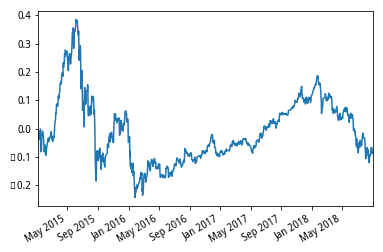

In [9]:
market_yield = np.cumsum(data_total_pd['market_yield'])

# 画图
market_yield.plot()


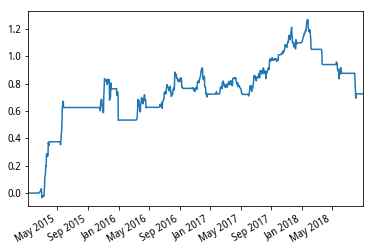

In [11]:
portfolio_yield = np.cumsum(data_total_pd['adjust_yield'])

# 画图
portfolio_yield.plot()

依据markov模型进行状态的画图

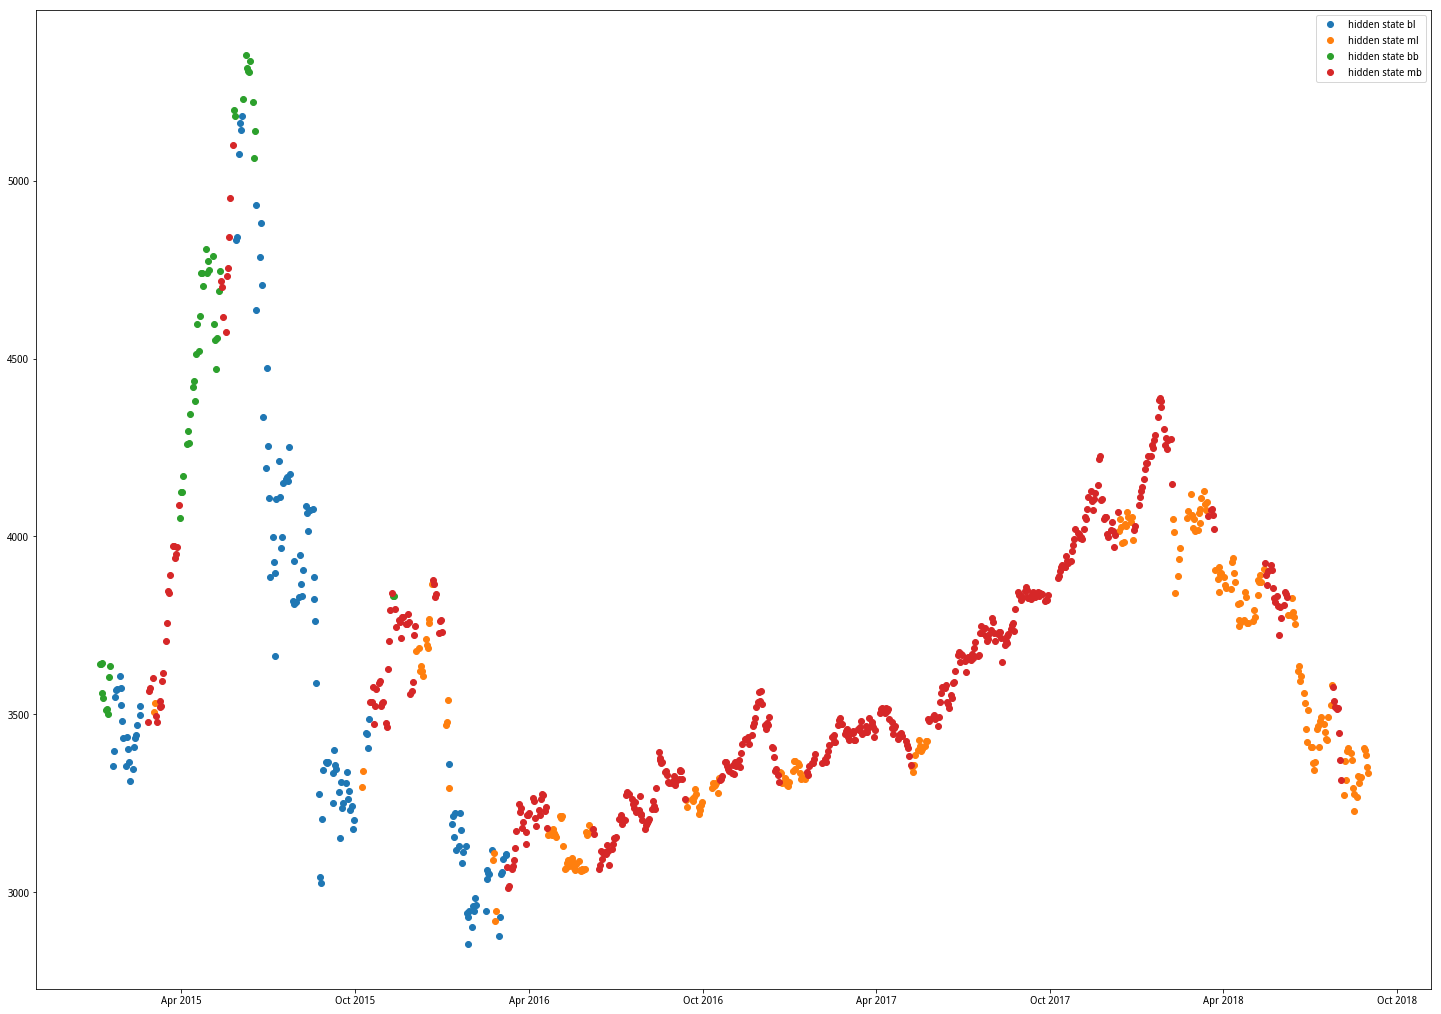

In [12]:
# 画图
Date = data_total_pd.index

s_date = Date[0]
e_date = Date[-1]
close = get_price('000300.XSHG', start_date = s_date, end_date=e_date, frequency='daily', fields=['close'],fq = "pre")['close']

plt.figure(figsize=(25, 18)) 

for i in ['bl','ml','bb','mb']:
    pos = list(data_total_pd['state']==i)
    x = data_total_pd[pos].index
    y = close[pos]

    plt.plot_date(x,y,'o',label='hidden state %s'%i,lw=2)
    plt.legend(loc="left")

3、计算大盘择时参数

每个状态的参数都按照一个比例进行计算，计算一段时间内（这段时间也是未来的参数）的仓位参数，通过仓位参数计算出收益率，标准有两个
1. 总的收益率越高
2. 失败概率最低

在每天的价格上增加了仓位的调整系数，这个系数是一个：持仓／总资产的数量（大于等于0）

t时刻的资产：持股资产比例 ＋ 现金资产比例

t时刻的资产：$$ 持股资产比例 * P（t+1) / P (t) + 现金资产比例 $$

引入t 时刻的持股资产比例 alpha

t 时刻的资产：$$ alpha * 1 + （1 - alpha）*1 = 1 $$
 
t + 1 时刻的资产：$$ alpha * 1 * P（t + 1) / P (t) + (1-alpha) * 1 $$

对数资产收益率：

$$ log ( alpha * 1* \frac {P（t+1)} {P (t)}  + (1-alpha)*1) 
/  1  $$

$$ log ( 1 + alpha * \frac {P(t+1) - P(t)}{P(t)} )$$

如果alpha为1，则回归到上面的公式$log(\frac {P(t+1)}{P(t)})$

聚宽平台利用pickle模块写入相关的变量，利用文件变量open函数

In [ ]:

import pickle
model_HMM = GHMM_Generate('000300.XSHG')
pickle.dump(model_HMM,open('HMM.pkl', 'wb'))
